In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
# Reference - CIFAR-10 : https://howtolivelikehuman.tistory.com/95
# Metric : https://velog.io/@jadon/F1-score%EB%9E%80
# Pytorch cifar10 : https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

<ipython-input-16-6d76feb8e3f5>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [17]:
# 전처리
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5))]) # pixel(0 ~ 255) -> pytorch tensor type(0.0 ~ 1.0), 각 채널별로 0.5 (X - mean) / std
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
print(transform)

Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=0.5)
)


In [18]:
# 데이터셋 로드
trainset = torchvision.datasets.MNIST(root='./data',
                                     train=True,
                                     download=True,
                                     transform=transform)

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

In [7]:
!cat /etc/*release
!head /proc/cpuinfo
!head -n 3 /proc/meminfo

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=22.04
DISTRIB_CODENAME=jammy
DISTRIB_DESCRIPTION="Ubuntu 22.04.2 LTS"
PRETTY_NAME="Ubuntu 22.04.2 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.2 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
MemTotal:       13294208 kB
MemFree:         9304156 kB
MemAvailable:   11862248 kB


In [20]:
'''
num_workers = 4 * num_GPU (or 8, 16, 2 * num_GPU)
entry * batch_size * num_worker = num_GPU * GPU_throughtput
num_workers = batch_size / num_GPU
num_workers = batch_size / num_CPU
'''
train_loader = DataLoader(trainset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(trainset,
                         batch_size=128,
                         shuffle=True,
                         num_workers=2)

print(len(trainset))

60000


In [21]:
image, label = next(iter(train_loader))

In [23]:
image.shape, label.shape
# torch의 input shape : batch, channel, height, width

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [24]:
'''
numpy.array : 너비 x 높이 x 채널(rgb)  h, w, c
전치 행렬 : (1, 2, 0)
'''
def imshow(img):
  img = img / 2 + 0.5 # 정규화 해제
  npimg = img.numpy()
  fig = plt.figure(figsize=(10, 5))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

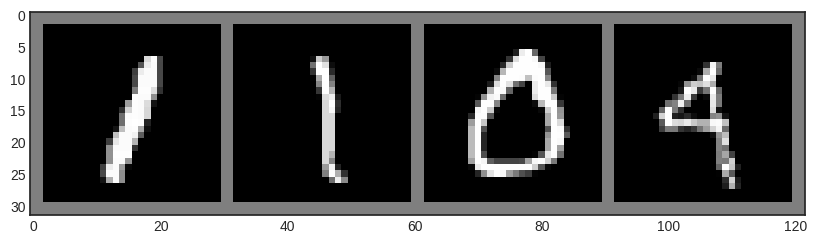

In [27]:
#dataiter = iter(train_loader)
images, labels = next(iter(train_loader)) # dataiter.next()에서 변경
imshow(torchvision.utils.make_grid(images[:4]))

- Max Pooling
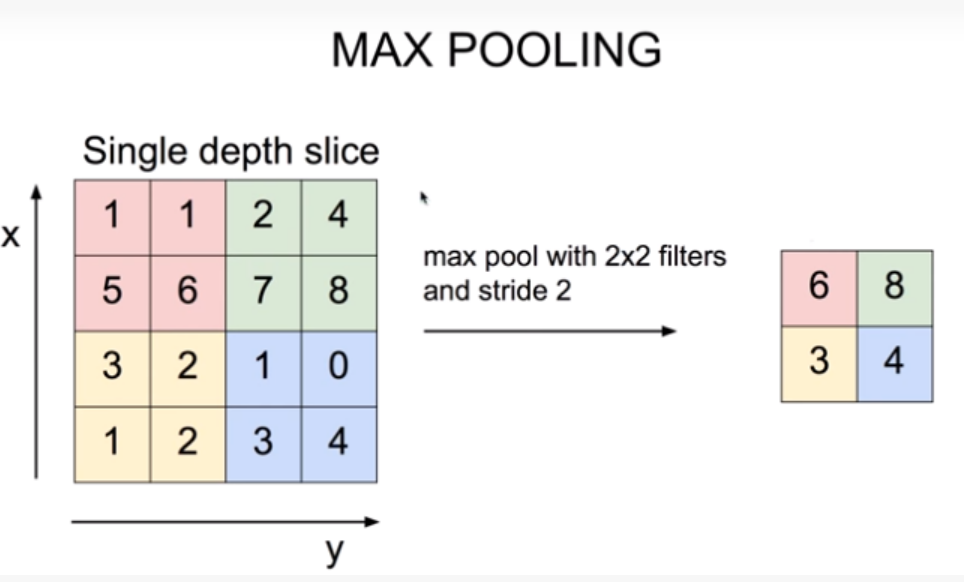
- VGGNet
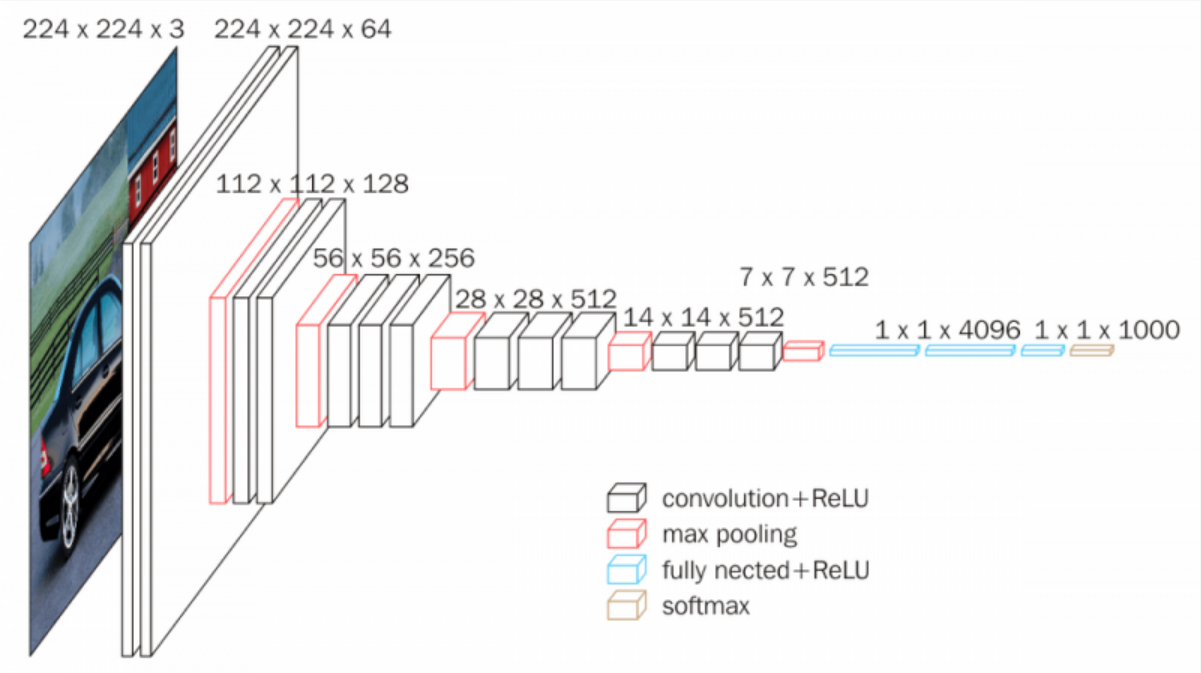

- Fully Connected Layer은 3차원 데이터를 input으로 넣기 위해 1차원의 평평한 데이터를 펼쳐서 넣었는데(28*28*1), 데이터의 3차원 형상을 살리면서 학습하게 만든 모델 CNN
- LeNet-5

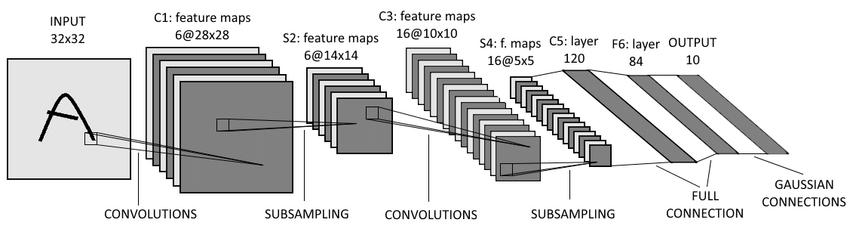

In [13]:
# 신경망 구성
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, 3) # 입력 이미지 1, 출력 6, 3x3 행렬
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.fc1 = nn.Linear(16 * 5 * 5, 120) # 아핀(affine 연산) : y = Wx + b, 5 * 5는 이미지 차원
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # 2, 2 윈도우에 대해 맥스 풀링
    x = F.max_pool2d(F.relu(self.conv2(x)), 2) # 제곱수라면 하나의 숫자만을 특정, 제곱근
    x = x.view(-1, self.num_flat_features(x)) # 배치 차원을 제외한 모든 차원을 하나로 평탄화
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s

    return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [14]:
# Parameter
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


In [28]:
# forward 값 확인
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

tensor([[-0.0279, -0.0574, -0.0400, -0.0535, -0.0073,  0.0891,  0.0131,  0.1093,
          0.0196,  0.0390]], grad_fn=<AddmmBackward0>)


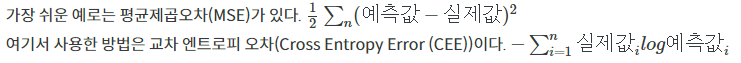
- learning rate : 한번에 얼마씩 바꿀 것인가
- gradient : 기울기 -> 기울기가 작은 쪽으로, 물을 뜨거운 물로 차가운 물로 틀 것이냐
- SGD : 매번 실행할 때 마다 기울기를 계산해서 바꾸는 것이 아닌 확률적(Stochastic)으로 선택된 부분마다 바꾸는 방법
- momentum : 관성 즉 이전 방향을 참고하여 같은 방향으로 일정한 방향만 수정하게 하는 방법, 이전 그래디언트의 가중 평균을 사용하여 현재를 업데이트 0보다 크면 최적화 적용, 일반적으로 0.9 사용
- lr : learning rate로 가중치를 업데이트 할 때 사용되는 스칼라 값, 학습률은 모델이 얼마나 빠르게 수렴할지를 결정하는 하이퍼파라미터, 너무 작으면 학습이 느리게 되고 너무 크면 발산할 수 있음

In [31]:
# Loss Function과 Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)

In [32]:
# 모델 학습
# 1. optimizer.zero_grad : 가중치의 그래디언트 초기화, 2. loss 계산, 3. loss.backward() : 기울기 계산, 4. optimizer.step() : 업데이트
total_batch = len(train_loader)
print(total_batch)

469


In [33]:
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      print("Epoch : {}, Iter: {}, Loss: {}".format(epoch+1, i+1, running_loss / 100)) # Iter로 나누기
      running_loss = 0.0

Epoch : 1, Iter: 100, Loss: 2.3019244623184205
Epoch : 1, Iter: 200, Loss: 2.2969428300857544
Epoch : 1, Iter: 300, Loss: 2.2900274777412415
Epoch : 1, Iter: 400, Loss: 2.282010004520416
Epoch : 2, Iter: 100, Loss: 2.255611090660095
Epoch : 2, Iter: 200, Loss: 2.2204274845123293
Epoch : 2, Iter: 300, Loss: 2.132883291244507
Epoch : 2, Iter: 400, Loss: 1.8747963976860047


In [34]:
# 모델 저장 및 로드
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [35]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

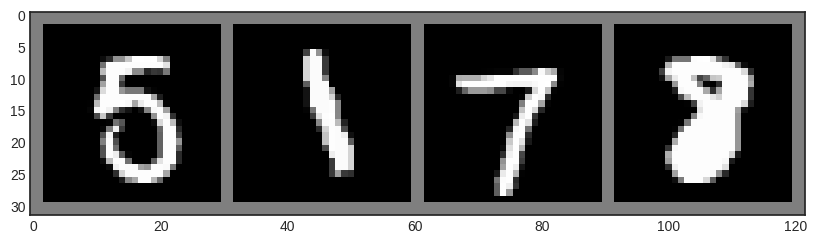

In [38]:
# 모델 테스트
images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images[:4]))

In [39]:
outputs = net(images)

In [40]:
_, predicted = torch.max(outputs, 1) # 텐서값 빼고 indices 만
print(predicted)

tensor([5, 1, 7, 8, 5, 6, 9, 4, 1, 1, 2, 0, 1, 4, 3, 6, 3, 3, 2, 0, 3, 6, 0, 0,
        9, 7, 7, 7, 6, 7, 0, 0, 1, 3, 5, 1, 3, 5, 2, 2, 6, 6, 1, 4, 1, 1, 4, 2,
        0, 0, 1, 7, 6, 6, 3, 9, 6, 0, 6, 7, 7, 6, 7, 4, 8, 1, 1, 0, 9, 7, 4, 1,
        1, 2, 8, 1, 8, 0, 6, 3, 1, 5, 4, 3, 2, 0, 9, 6, 3, 0, 2, 8, 4, 1, 1, 8,
        6, 1, 2, 1, 7, 2, 7, 2, 2, 1, 7, 2, 7, 1, 8, 7, 4, 6, 2, 9, 8, 8, 6, 9,
        4, 9, 4, 1, 7, 3, 3, 9])


In [43]:
print(''.join('{}\t'.format(str(predicted[j].numpy())) for j in range(4)))

5	1	7	8	


In [44]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1) # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print("Accuracy :", 100 * correct / total)

Accuracy : 70.85166666666667


In [2]:
'''
<GPU 버전 - 런타임 유형 변경!>
'''
# re import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

<ipython-input-2-516919373f71>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [3]:
# GPU 설정
torch.cuda.is_available()

True

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
device

device(type='cuda')

In [17]:
# 데이터 로드 다시

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5))])

trainset = torchvision.datasets.MNIST(root='./data',
                                     train=True,
                                     download=True,
                                     transform=transform)

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

train_loader = DataLoader(trainset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(trainset,
                          batch_size=128,
                          shuffle=True,
                         num_workers=2)

In [18]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s

    return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [19]:
# 모델 cuda로 보내기
net = Net().to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)

In [21]:
for epoch in range(5):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device) # 데이터 -> cuda
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      print("Epoch : {}, Iter: {}, Loss: {}".format(epoch+1, i+1, running_loss / 100))
      running_loss = 0.0

Epoch : 1, Iter: 100, Loss: 2.3042738366127016
Epoch : 1, Iter: 200, Loss: 2.300901002883911
Epoch : 1, Iter: 300, Loss: 2.297031991481781
Epoch : 1, Iter: 400, Loss: 2.2929615283012392
Epoch : 2, Iter: 100, Loss: 2.284592673778534
Epoch : 2, Iter: 200, Loss: 2.2765464425086974
Epoch : 2, Iter: 300, Loss: 2.265311686992645
Epoch : 2, Iter: 400, Loss: 2.2457066488265993
Epoch : 3, Iter: 100, Loss: 2.156715157032013
Epoch : 3, Iter: 200, Loss: 1.9776500046253205
Epoch : 3, Iter: 300, Loss: 1.508329653739929
Epoch : 3, Iter: 400, Loss: 0.9496527981758117
Epoch : 4, Iter: 100, Loss: 0.5028660553693771
Epoch : 4, Iter: 200, Loss: 0.4027027088403702
Epoch : 4, Iter: 300, Loss: 0.35547413513064385
Epoch : 4, Iter: 400, Loss: 0.31738034218549727
Epoch : 5, Iter: 100, Loss: 0.25452758073806764
Epoch : 5, Iter: 200, Loss: 0.24651590883731841
Epoch : 5, Iter: 300, Loss: 0.23051254652440548
Epoch : 5, Iter: 400, Loss: 0.2123988837748766


In [22]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device) # 데이터 -> cuda
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print("Accuracy :", 100 * correct / total)

Accuracy : 94.18333333333334
